# Series de Fourier
## Análisis y Síntesis de Señales Periódicas

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import ipywidgets as widgets
from IPython.display import display

from labs.serie_fourier import (
    FourierSeries,
    onda_cuadrada,
    onda_triangular,
    onda_diente_sierra,
    impulso_periodico,
    calcular_potencia,
)

plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## 1. Introducción Teórica

### Series de Fourier - Forma Trigonométrica
Una señal periódica $f(t)$ con período $T$ puede expresarse como:

$$f(t) = \frac{a_0}{2} + \sum_{n=1}^{\infty} [a_n \cos(n\omega_0 t) + b_n \sin(n\omega_0 t)]$$

donde $\omega_0 = \frac{2\pi}{T}$ y los coeficientes son:

$$a_0 = \frac{2}{T} \int_{-T/2}^{T/2} f(t) dt$$

$$a_n = \frac{2}{T} \int_{-T/2}^{T/2} f(t) \cos(n\omega_0 t) dt$$

$$b_n = \frac{2}{T} \int_{-T/2}^{T/2} f(t) \sin(n\omega_0 t) dt$$

### Series de Fourier - Forma Exponencial Compleja
$$f(t) = \sum_{n=-\infty}^{\infty} c_n e^{jn\omega_0 t}$$

donde:
$$c_n = \frac{1}{T} \int_{-T/2}^{T/2} f(t) e^{-jn\omega_0 t} dt$$

### Equivalencia entre Coeficientes

La relación entre los coeficientes trigonométricos y exponenciales complejos es:

$$c_0 = \frac{a_0}{2}$$

Para $n > 0$:
$$c_n = \frac{a_n - jb_n}{2}$$

$$c_{-n} = \frac{a_n + jb_n}{2} = c_n^*$$

Y la conversión inversa:
$$a_0 = 2c_0$$

$$a_n = c_n + c_{-n} = 2\text{Re}(c_n)$$

$$b_n = j(c_n - c_{-n}) = -2\text{Im}(c_n)$$

**Nota importante:** Los coeficientes exponenciales complejos $c_n$ para $n < 0$ son el conjugado complejo de $c_{-n}$, lo que refleja la simetría hermítica para señales reales.

## 2. Ejemplo 1: Onda Cuadrada

Comenzaremos analizando una onda cuadrada, una de las señales más utilizadas en el análisis de Fourier.

Coeficientes exponenciales complejos (primeros 10):
Número de coeficientes: 121
C[-5] =  -0.0002 + j  0.0002 =   0.0003∠ 135.0°
C[-4] =   0.0002 + j -0.0000 =   0.0002∠  -0.0°
C[-3] =  -0.0002 + j -0.0002 =   0.0003∠-135.0°
C[-2] =   0.0002 + j  1.2731 =   1.2731∠  90.0°
C[-1] =  -0.0002 + j  0.0002 =   0.0003∠ 135.0°
C[ 0] =   0.0002 + j  0.0000 =   0.0002∠   0.0°
C[ 1] =  -0.0002 + j -0.0002 =   0.0003∠-135.0°
C[ 2] =   0.0002 + j -1.2731 =   1.2731∠ -90.0°
C[ 3] =  -0.0002 + j  0.0002 =   0.0003∠ 135.0°
C[ 4] =   0.0002 + j  0.0000 =   0.0002∠   0.0°
C[ 5] =  -0.0002 + j -0.0002 =   0.0003∠-135.0°


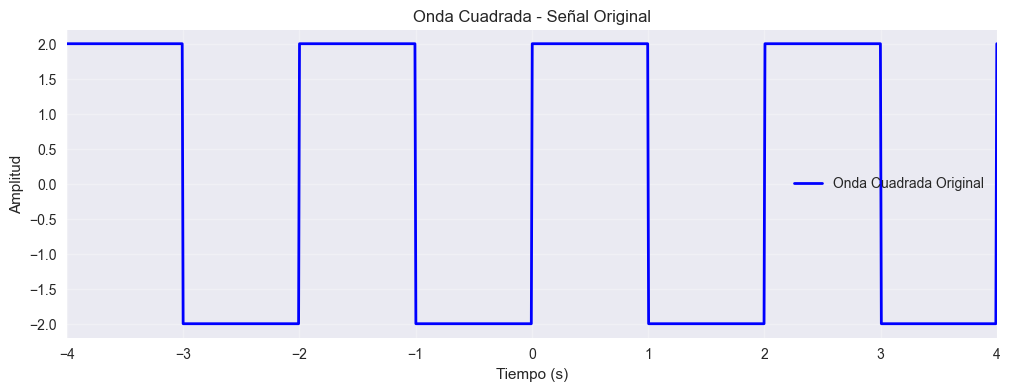

In [27]:
T = 4
fs = FourierSeries(periodo=T)

t_vis = np.linspace(-T, T, 1000)

cuadrada = lambda t: onda_cuadrada(t, amplitud=2, duty_cycle=0.5)
y_original = cuadrada(t_vis)

n_vector, cn = fs.coeficientes_exponenciales(cuadrada, n_harmonicos=60)

print(f"Coeficientes exponenciales complejos (primeros 10):")
print(f"Número de coeficientes: {len(cn)}")
for i, (n, c) in enumerate(zip(n_vector, cn)):
    if abs(n) <= 5:
        print(f"C[{n:2d}] = {c.real:8.4f} + j{c.imag:8.4f} = {abs(c):8.4f}∠{np.angle(c)*180/np.pi:6.1f}°")

plt.figure(figsize=(12, 4))
plt.plot(t_vis, y_original, 'b-', linewidth=2, label='Onda Cuadrada Original')
plt.grid(True, alpha=0.3)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Onda Cuadrada - Señal Original')
plt.legend()
plt.xlim(-T, T)
plt.show()

### Aproximaciones con Diferentes Números de Armónicos

In [29]:
def sintetizar_serie_exponencial(n_vector, cn, t, n_terminos=None):
    if n_terminos is None:
        indices = np.arange(len(cn))
    else:
        centro = len(cn) // 2
        inicio = max(0, centro - n_terminos)
        fin = min(len(cn), centro + n_terminos + 1)
        indices = np.arange(inicio, fin)

    omega0 = 2 * np.pi / T
    resultado = np.zeros_like(t, dtype=complex)

    for i in indices:
        n = n_vector[i]
        resultado += cn[i] * np.exp(1j * n * omega0 * t)

    return np.real(resultado)

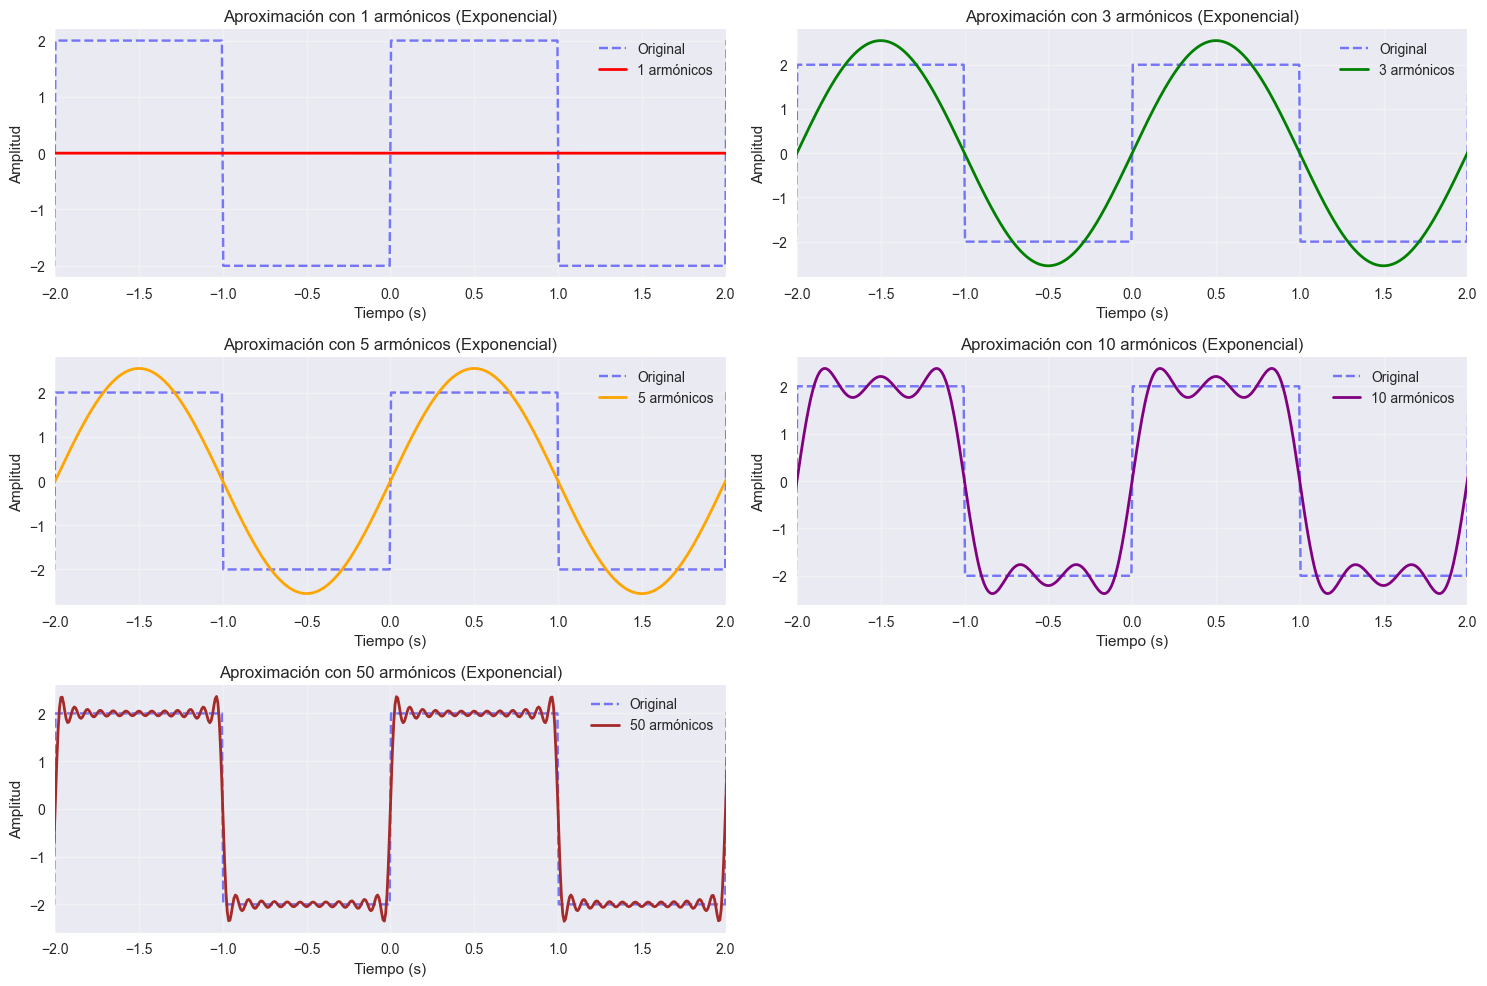


Error RMS vs Número de Armónicos (Síntesis Exponencial):
 1 armónicos: Error RMS = 2.000001
 3 armónicos: Error RMS = 0.872339
 5 armónicos: Error RMS = 0.872340
10 armónicos: Error RMS = 0.521089
50 armónicos: Error RMS = 0.257629


In [32]:
n_terminos_list = [1, 3, 5, 10, 50]
colores = ['red', 'green', 'orange', 'purple', 'brown']

plt.figure(figsize=(15, 10))

for i, n_terminos in enumerate(n_terminos_list):
    plt.subplot(3, 2, i+1)

    y_aprox = sintetizar_serie_exponencial(n_vector, cn, t_vis, n_terminos)

    plt.plot(t_vis, y_original, 'b--', alpha=0.5, label='Original')
    plt.plot(t_vis, y_aprox, colores[i], linewidth=2, label=f'{n_terminos} armónicos')

    plt.grid(True, alpha=0.3)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title(f'Aproximación con {n_terminos} armónicos (Exponencial)')
    plt.legend()
    plt.xlim(-T/2, T/2)

plt.tight_layout()
plt.show()

print("\nError RMS vs Número de Armónicos (Síntesis Exponencial):")
for n_terminos in n_terminos_list:
    y_aprox = sintetizar_serie_exponencial(n_vector, cn, t_vis, n_terminos)
    error_rms = np.sqrt(np.mean((y_original - y_aprox)**2))
    print(f"{n_terminos:2d} armónicos: Error RMS = {error_rms:.6f}")

## 3. Espectro de Frecuencias

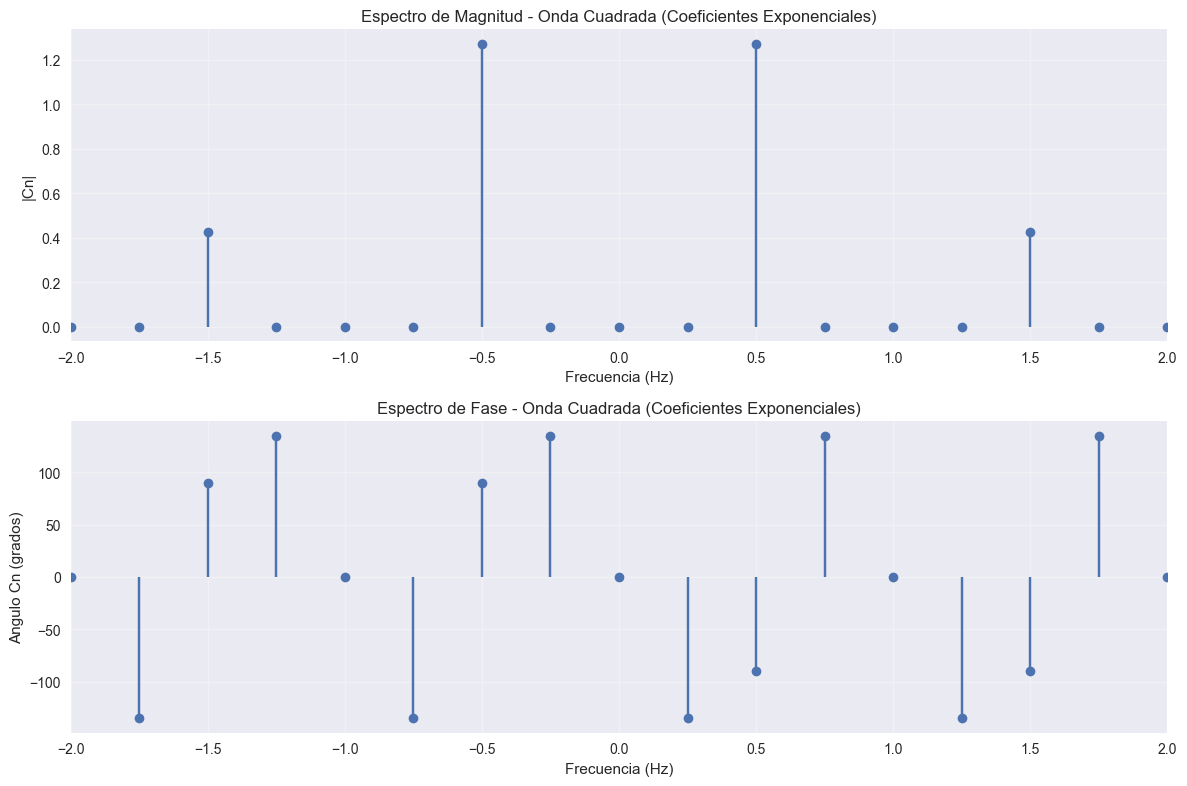

In [18]:
frecuencias = n_vector * fs.omega0 / (2 * np.pi)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

magnitudes = np.abs(cn)
ax1.stem(frecuencias, magnitudes, basefmt=" ")
ax1.set_xlabel('Frecuencia (Hz)')
ax1.set_ylabel('|Cn|')
ax1.set_title('Espectro de Magnitud - Onda Cuadrada (Coeficientes Exponenciales)')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-2, 2)

fases = np.angle(cn) * 180 / np.pi
ax2.stem(frecuencias, fases, basefmt=" ")
ax2.set_xlabel('Frecuencia (Hz)')
ax2.set_ylabel('Angulo Cn (grados)')
ax2.set_title('Espectro de Fase - Onda Cuadrada (Coeficientes Exponenciales)')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-2, 2)

plt.tight_layout()
plt.show()

## 4. Comparación entre Diferentes Señales

Analicemos y comparemos diferentes tipos de señales periódicas.

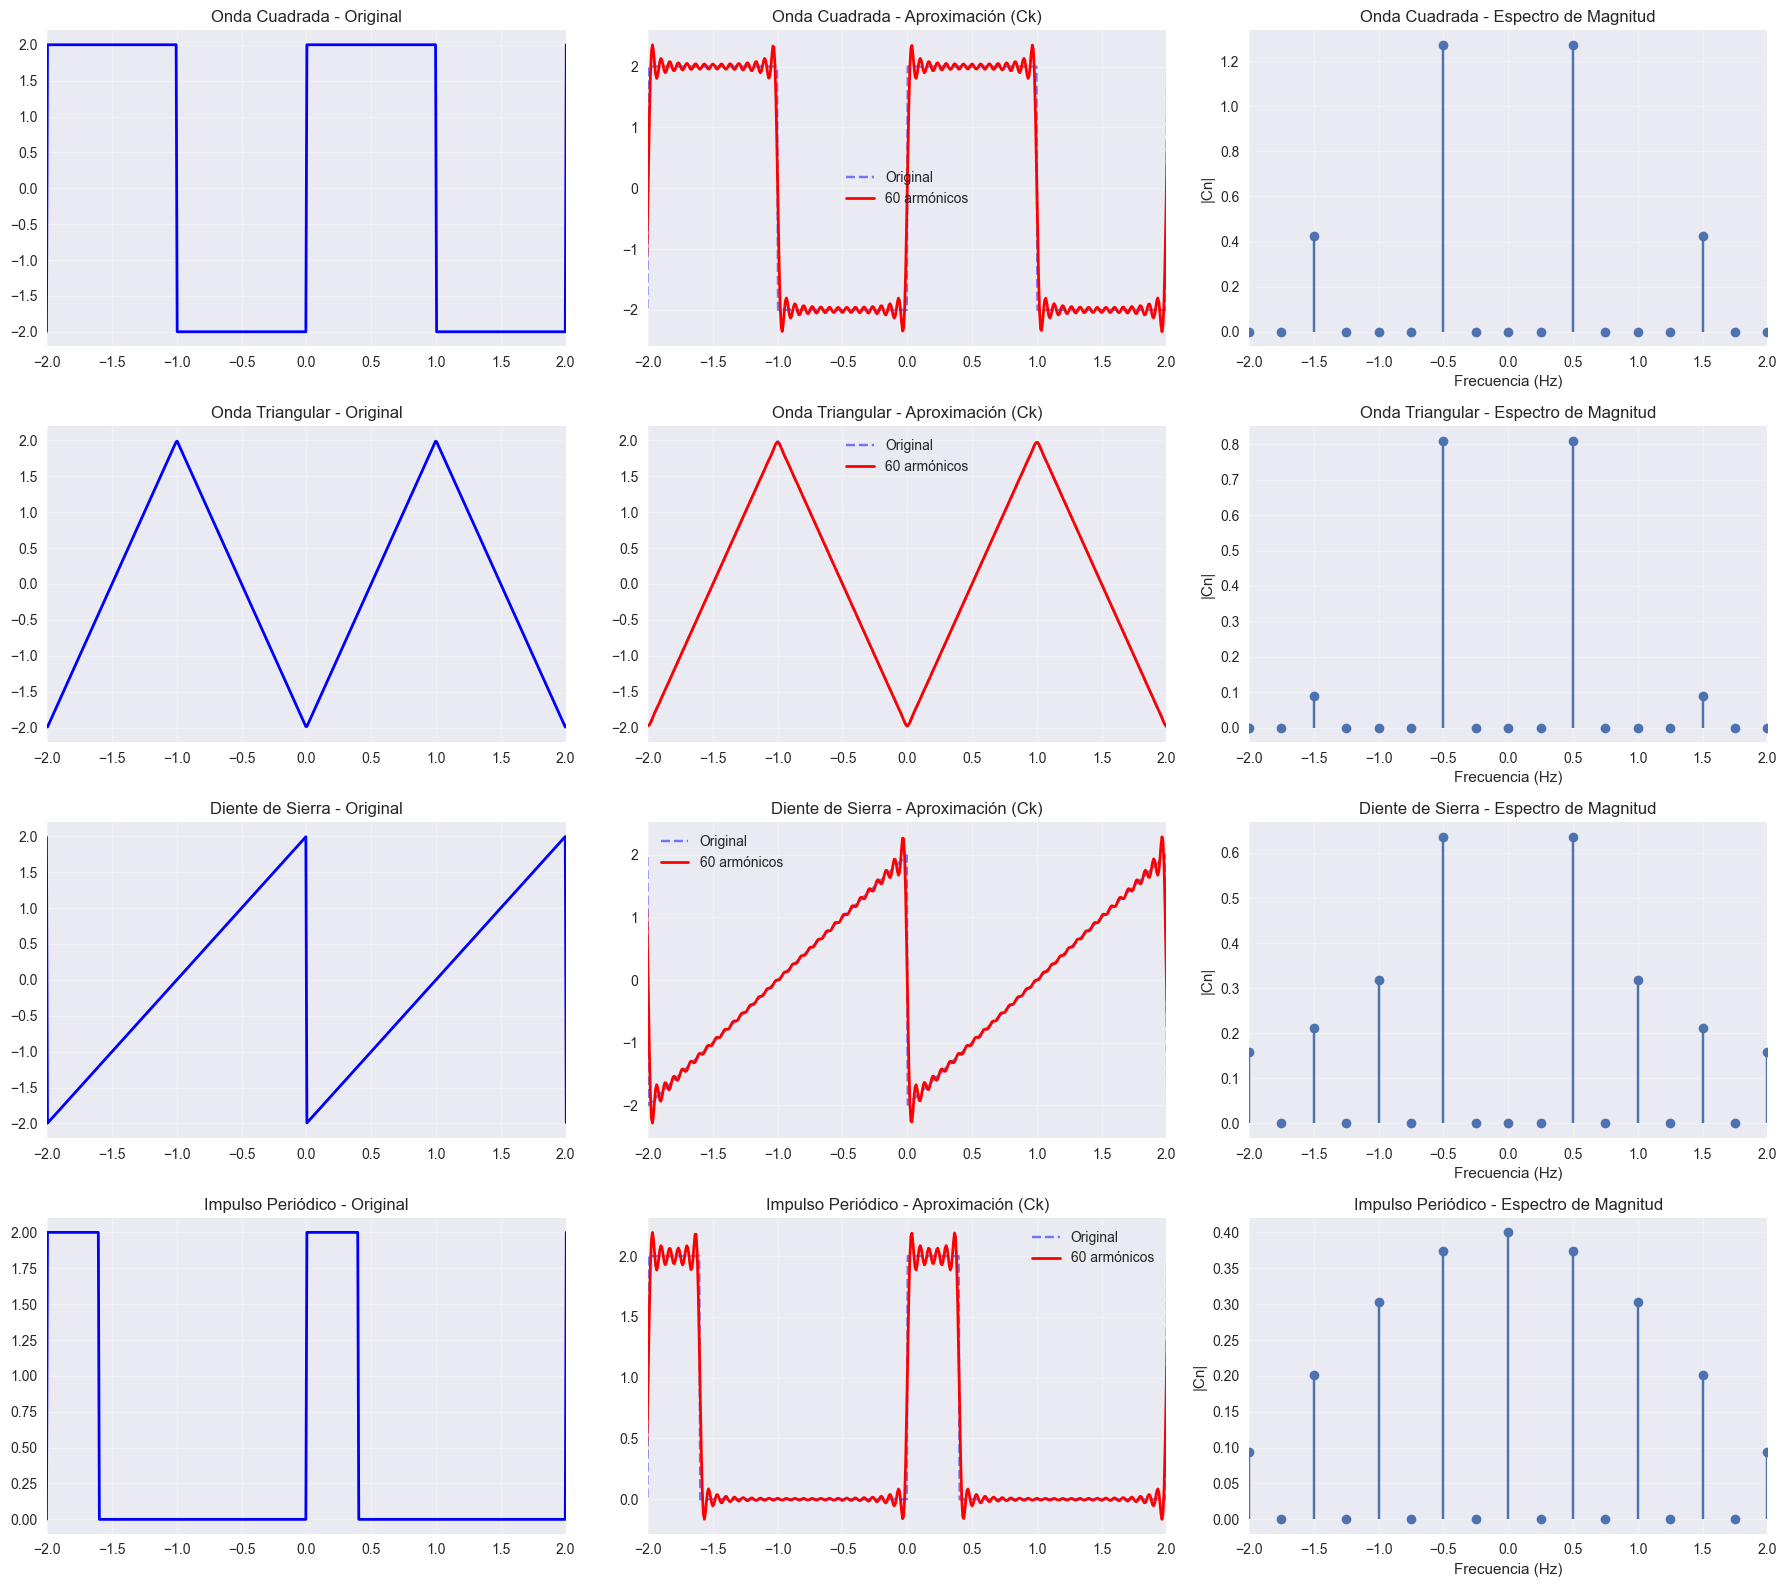

In [36]:
senales = {
    'Onda Cuadrada': lambda t: onda_cuadrada(t, amplitud=2),
    'Onda Triangular': lambda t: onda_triangular(t, amplitud=2),
    'Diente de Sierra': lambda t: onda_diente_sierra(t, amplitud=2),
    'Impulso Periódico': lambda t: impulso_periodico(t, amplitud=2, ancho=0.2)
}

T = 4
fs = FourierSeries(periodo=T)
t_vis = np.linspace(-T, T, 1000)
n_harmonicos = 60

resultados = {}

fig, axes = plt.subplots(4, 3, figsize=(18, 16))

for i, (nombre, func) in enumerate(senales.items()):
    n_vector, cn = fs.coeficientes_exponenciales(func, n_harmonicos)

    resultados[nombre] = {'cn': cn, 'n_vector': n_vector}

    y_original = func(t_vis)
    axes[i, 0].plot(t_vis, y_original, 'b-', linewidth=2)
    axes[i, 0].set_title(f'{nombre} - Original')
    axes[i, 0].grid(True, alpha=0.3)
    axes[i, 0].set_xlim(-T/2, T/2)

    y_aprox = sintetizar_serie_exponencial(n_vector, cn, t_vis, n_harmonicos)
    axes[i, 1].plot(t_vis, y_original, 'b--', alpha=0.5, label='Original')
    axes[i, 1].plot(t_vis, y_aprox, 'r-', linewidth=2, label=f'{n_harmonicos} armónicos')
    axes[i, 1].set_title(f'{nombre} - Aproximación (Ck)')
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].legend()
    axes[i, 1].set_xlim(-T/2, T/2)

    frecuencias = n_vector * fs.omega0 / (2 * np.pi)
    magnitudes = np.abs(cn)
    axes[i, 2].stem(frecuencias, magnitudes, basefmt=" ")
    axes[i, 2].set_title(f'{nombre} - Espectro de Magnitud')
    axes[i, 2].grid(True, alpha=0.3)
    axes[i, 2].set_xlim(-2, 2)
    axes[i, 2].set_xlabel('Frecuencia (Hz)')
    axes[i, 2].set_ylabel('|Cn|')

plt.tight_layout()
plt.show()

## 6. Serie interactivo

### Exploración Interactiva de Aproximaciones

In [40]:
def visualizador_interactivo(tipo_senal='Cuadrada', n_armonicos=10, amplitud=2.0, duty_cycle=0.5):
    T = 4
    fs = FourierSeries(periodo=T)
    t_vis = np.linspace(-T, T, 1000)

    if tipo_senal == 'Cuadrada':
        func = lambda t: onda_cuadrada(t, amplitud, duty_cycle)
    elif tipo_senal == 'Triangular':
        func = lambda t: onda_triangular(t, amplitud)
    elif tipo_senal == 'Diente de Sierra':
        func = lambda t: onda_diente_sierra(t, amplitud)
    elif tipo_senal == 'Impulso Periódico':
        func = lambda t: impulso_periodico(t, amplitud, duty_cycle)

    n_vector, cn = fs.coeficientes_exponenciales(func, max(n_armonicos, 20))

    y_original = func(t_vis)
    y_aprox = sintetizar_serie_exponencial(n_vector, cn, t_vis, n_armonicos)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    ax1.plot(t_vis, y_original, 'b-', linewidth=2, label='Original', alpha=0.7)
    ax1.plot(t_vis, y_aprox, 'r-', linewidth=2, label=f'Aproximación ({n_armonicos} armónicos)')
    ax1.set_xlabel('Tiempo (s)')
    ax1.set_ylabel('Amplitud')
    ax1.set_title(f'Onda {tipo_senal} - Aproximación de Fourier (Exponencial)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-T/2, T/2)

    error_rms = np.sqrt(np.mean((y_original - y_aprox)**2))
    ax1.text(0.02, 0.95, f'Error RMS: {error_rms:.4f}',
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    frecuencias = n_vector * fs.omega0 / (2 * np.pi)
    magnitudes = np.abs(cn)

    mask = (np.abs(n_vector) <= n_armonicos) & (magnitudes > 1e-6)

    ax2.stem(frecuencias[mask], magnitudes[mask], basefmt=" ")
    ax2.set_xlabel('Frecuencia (Hz)')
    ax2.set_ylabel('|Cn|')
    ax2.set_title('Espectro de Magnitud - Coeficientes Exponenciales')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(-2, 2)

    plt.tight_layout()
    plt.show()

widgets_interactivo = widgets.interactive(
    visualizador_interactivo,
    tipo_senal=widgets.Dropdown(
        options=['Cuadrada', 'Triangular', 'Diente de Sierra', 'Impulso Periódico'],
        value='Cuadrada',
        description='Tipo de Señal:'
    ),
    n_armonicos=widgets.IntSlider(
        value=10,
        min=1,
        max=50,
        step=1,
        description='N° Armónicos:'
    ),
    amplitud=widgets.FloatSlider(
        value=2.0,
        min=0.5,
        max=5.0,
        step=0.1,
        description='Amplitud:'
    ),
    duty_cycle=widgets.FloatSlider(
        value=0.5,
        min=0.1,
        max=0.9,
        step=0.1,
        description='Duty Cycle:'
    )
)

# display(widgets_interactivo)

## 7. Análisis de Convergencia

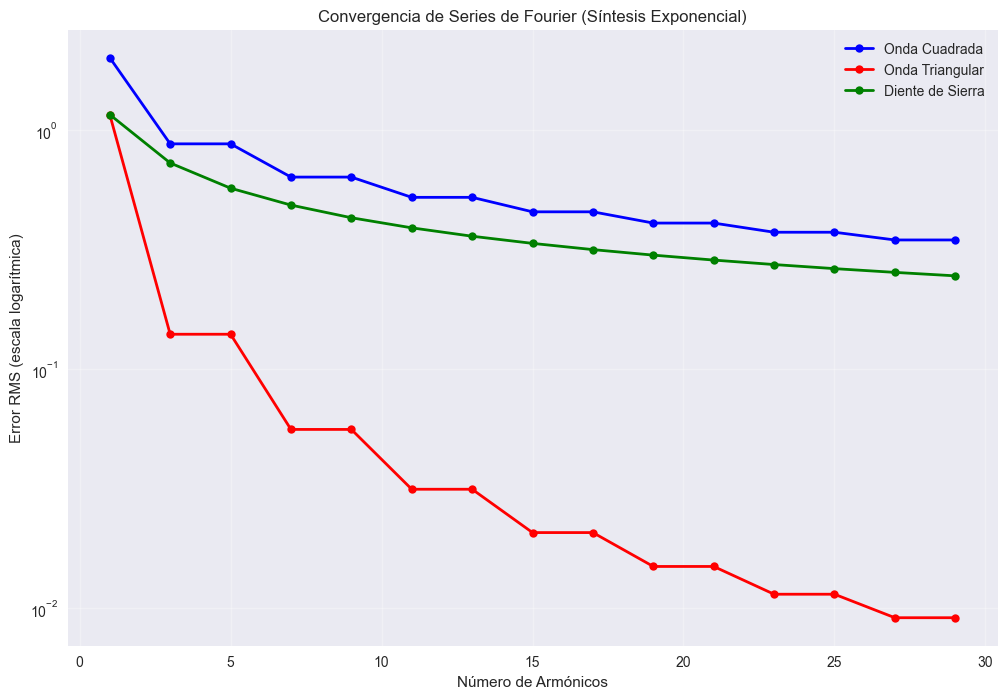

In [24]:
def analizar_convergencia_exponencial(func, nombre, max_armonicos=50):
    T = 4
    fs = FourierSeries(periodo=T)
    t_vis = np.linspace(-T/2, T/2, 1000)

    n_vector, cn = fs.coeficientes_exponenciales(func, max_armonicos)
    y_original = func(t_vis)

    n_armonicos_range = range(1, max_armonicos + 1, 2)
    errores_rms = []

    for n in n_armonicos_range:
        y_aprox = sintetizar_serie_exponencial(n_vector, cn, t_vis, n)
        error_rms = np.sqrt(np.mean((y_original - y_aprox)**2))
        errores_rms.append(error_rms)

    return list(n_armonicos_range), errores_rms

señales_convergencia = {
    'Onda Cuadrada': lambda t: onda_cuadrada(t, 2),
    'Onda Triangular': lambda t: onda_triangular(t, 2),
    'Diente de Sierra': lambda t: onda_diente_sierra(t, 2)
}

plt.figure(figsize=(12, 8))

colores = ['blue', 'red', 'green']
for i, (nombre, func) in enumerate(señales_convergencia.items()):
    n_vals, errores = analizar_convergencia_exponencial(func, nombre, 30)
    plt.semilogy(n_vals, errores, 'o-', color=colores[i],
                linewidth=2, markersize=6, label=nombre)

plt.xlabel('Número de Armónicos')
plt.ylabel('Error RMS (escala logarítmica)')
plt.title('Convergencia de Series de Fourier (Síntesis Exponencial)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()